<a href="https://colab.research.google.com/github/carlosbonilla2605/word_embed/blob/main/Train_a_custom_word_embedding_for_analogy_solving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving a verbal reasoning test with word embeddings (Analogies)

Author: Carlos Bonilla

In this notebook, I layout the results of an experiment that consisted in solving a verbal reasoning test using word embeddings. The final results were that a custom word embeddings model was able to correctly answer 81% of the verbal reasoning questions. 

The overall steps to achieve this were:

* Loaded a pre-trained word embeddings model called GloVe (**Model 1**). For more info on this model visit https://nlp.stanford.edu/projects/glove/
* Prepared functionality with the GloVe model to solve analogies of the form:
 * Word_A : Word_B :: Word_C : ?
 * or Word_A : Word_B :: ? : Word_D
* Used the pre-trained model to solve the questions from the analogies in this test https://www.123test.com/verbal-reasoning-test-analogies/
* The model predicted the correct answer to the analogies correctly in 5 out of 11 questions.
* Prepared a NEW model (**Model 2**), trained from scratch with manually generated training data. 
* Used the new model to answer correctly all of the analogies that the GloVe model failed to predict originally. 
* Intersected (or merged) **Model 1** and **Model 2** into a new **Model 3**. In other words, accumulated the understanding of **Model 2** into **Model 1**. 
* Finally, **Model 3** was able to solve correctly 9 out of 11 questions in the analogy test.

In short, the customized GloVe model increased its accuracy from 45% to 81%, without losing its generalization capabilities.

This is the detailed process followed for the experiment. Let's start by importing the libraries.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import time

#We will use GloVe data but the Word2Vec libraries
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

The following preprocessing function was adapted from https://www.kaggle.com/chewzy/tutorial-how-to-train-your-custom-word-embedding. Many different preprocessing techniques can be tried, in this case I just wanted to keep it simple and feed meaningful words to enhance the capabilities of the word embeddings of learning from context. In other words, I cleaned and simplified the inputs so that it could learn quicker with less examples.

In [2]:
def preprocessing(sentence_array):
    processed_array = []
    
    for sentence in sentence_array:
        
        # remove other non-alphabets symbols with space (i.e. keep only alphabets and whitespaces).
        processed = re.sub('[^a-zA-Z ]', '', sentence)
        
        words = processed.lower().split()
        
        # keep words that have length of more than 1 (e.g. gb, bb), remove those with length 1.
        processed_array.append([word for word in words if len(word) > 1])
    
    return processed_array

The first model (**Model 1**) that we try here is the pretrained GloVe model, with 400,000 words and 300 dimensions. We load the model directly from the word embeddings vectors. I downloaded the data from this link https://www.kaggle.com/thanakomsn/glove6b300dtxt

In [4]:
#Load model 1 from pre-trained GloVe word embeddings
model_1 = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)

Now, let's define a few functions to compute analogies with different trained models.

Functions to:
* Calculate the best 8 possible values to solve the analogy.
* Compute the score or strength of an analogy.
* Solve a multiple choice analogy question by computing the scores and keeping the highest.

In [5]:
# Calculate the best 8 possible values to solve the analogy.
def calculate_analogy_words(model, word1, word2, word3):
  """ 
  Perform the arithmetic of words word3 - word1 + word2
  This is the usual case of king - man + woman = queen
  """

  return model.most_similar(positive=[word3, word2], negative=[word1], topn=8)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Compute the score or strength of an analogy.
def calculate_analogy_score(model, word1, word2, word3, word4):
  """ 
  Calculate the score or strength of an analogy. The idea is to compute 
  the similarity of the vector differences:

  score = similarity(word1 - word2 , word3 - word4)
  """

  sum_vec1 =np.zeros(300)
  sum_vec2 =np.zeros(300)
  sum_vec3 =np.zeros(300)
  sum_vec4 =np.zeros(300)

  #This section is just to deal with composite words as "North America"
  if len(word1.split()) > 1:
    for word in word1.split():
       sum_vec1 += model.wv[word]
    sum_vec1 = sum_vec1 / len(word1.split())
  else:
    sum_vec1 = model.wv[word1]

  if len(word2.split()) > 1:
    for word in word2.split():
       sum_vec2 += model.wv[word]
    sum_vec2 = sum_vec2 / len(word2.split())
  else:
    sum_vec2 = model.wv[word2]

  if len(word3.split()) > 1:
    for word in word3.split():
       sum_vec3 += model.wv[word]
    sum_vec3 = sum_vec3 / len(word3.split())
  else:
    sum_vec3 = model.wv[word3]

  if len(word4.split()) > 1:
    for word in word4.split():
       sum_vec4 += model.wv[word]
    sum_vec4 = sum_vec4 / len(word4.split())
  else:
    sum_vec4 = model.wv[word4]

  #Analogy score calculation
  meaning_1 = sum_vec1 - sum_vec2
  meaning_2 = sum_vec3 - sum_vec4
  similarity = cosine_similarity( [meaning_1], [meaning_2])
  return similarity


# Solve a multiple choice analogy question by computing the scores and keeping the highest.
def solve_analogy_problem(model, input, options, debug=False):
  """
  This function takes the input and the options in a multiple choice question
  and computes the score of the analogy for every combination keeping the best
  """

  score_max = -100
  for option in options:

    #Call the analogy score function for every option
    score = calculate_analogy_score(model, input[0], input[1], option[0], option[1])

    #Just for debugging purposes
    if debug:
      print(input, " as ", option, "with a score of", score[0])

    #Keep the max
    if score > score_max:
      score_max = score
      option_max = option
  return option_max, score_max

# -----------Example of use------------------
input=('mason', 'stone')
options = [('soldier', 'weapon'),('lawyer','law'),('blacksmith', 'forge'),('teacher', 'pupil'),('carpenter', 'wood')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])


('mason', 'stone')  as  ('carpenter', 'wood') with a score of [0.25874722]


## Solving the analogy test with the pre-trained GloVe model (**Model 1**)

Here we use the pre-trained GloVe word embeddings to solve 11 analogy questions from this test https://www.123test.com/verbal-reasoning-test-analogies/

#### **1) evening is to morning as dinner is to ?**

Using the previously defined functions we get "breakfast" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('evening', 'morning')
options = [('dinner', 'breakfast'),('dinner','soup'),('dinner', 'coffee'),('dinner', 'time')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('evening', 'morning')  as  ('dinner', 'breakfast') with a score of [0.35718834]


And according to the test, GloVe got this answer right.

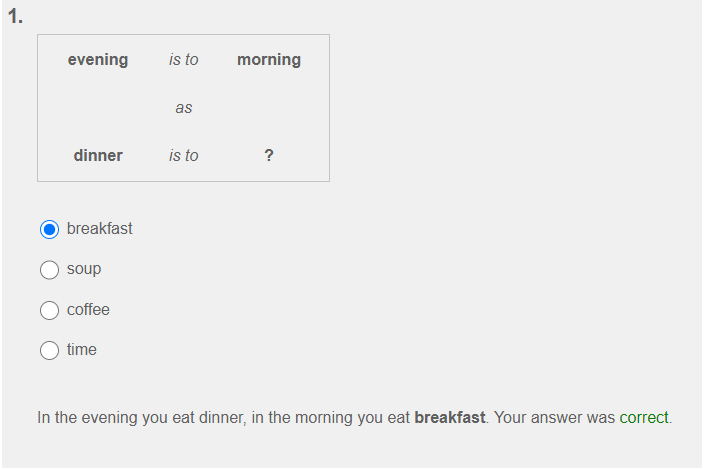

#### **2) left is to right as horizontal is to ?**

Using the previously defined functions we get "vertical" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('left', 'right')
options = [('horizontal', 'below'),('horizontal','middle'),('horizontal', 'down'),('horizontal', 'vertical')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('left', 'right')  as  ('horizontal', 'vertical') with a score of [0.06481194]


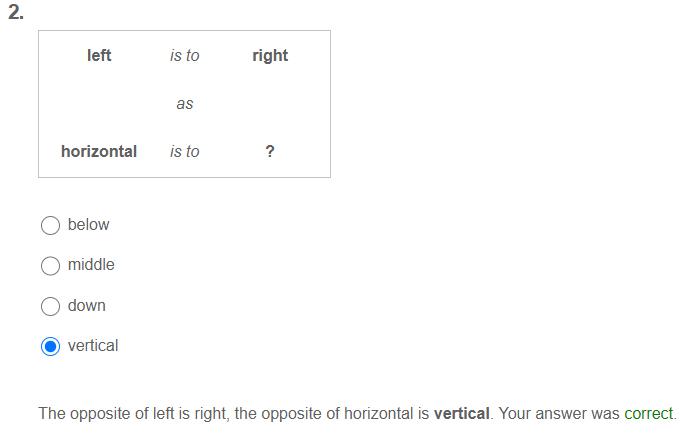

And according to the test, GloVe got this answer right.

#### **3) all is to many as few is to ?**

Using the previously defined functions we get "some" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('all', 'many')
options = [('few', 'some'),('few','never'),('few', 'none'),('few', 'always')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('all', 'many')  as  ('few', 'some') with a score of [0.05149691]


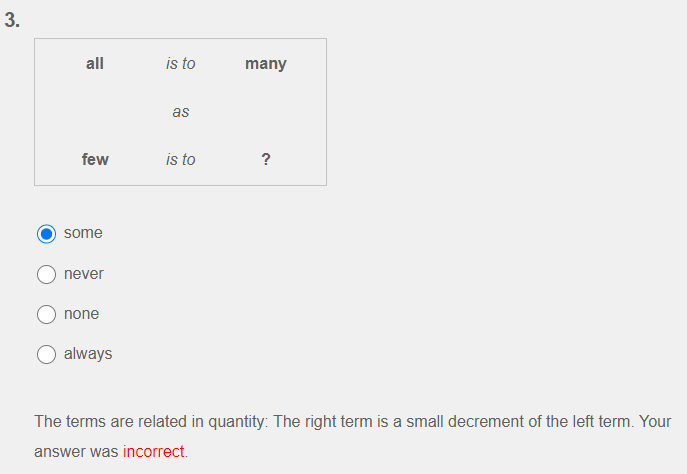

This answer was incorrect. The analogy score was only 0.05 for ["all" - "many", "few" - "some"]. It seems that the "understanding" captured in the word embedding vectors does not contain the idea that the problem is intending to evaluate. The idea is that words can be related in the terms of the quantity they represent. This is a challenging concept for a machine to undertand, specially with the use of word embeddings since quantities are not inherently teached through language, but rather by human intuitions and math classes.

#### **4) hip is to ankle as shoulder is to ?**

Using the previously defined functions we get "knee" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('hip', 'ankle')
options = [('shoulder', 'knee'),('shoulder','bone'),('shoulder', 'wrist'),('shoulder', 'joint')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('hip', 'ankle')  as  ('shoulder', 'knee') with a score of [0.23596345]


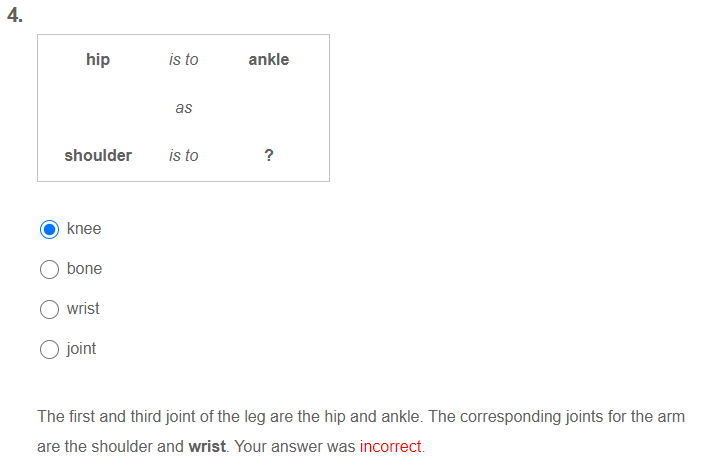

Interestingly, this answer was also incorrect. Arguably, there is something correct about "knee" as an answer, as hip and ankle are also part of the lower body. However, the actual relationship was a little bit obscure for a machine to understand, specially since the comparison is rarely explicitly described in any text corpus we can think of. 

####  **5) butcher is to knife as hairdresser is to ?**

Using the previously defined functions we get "scissors" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('butcher', 'knife')
options = [('hairdresser', 'scissors'),('hairdresser','hair'),('hairdresser', 'curls'),('hairdresser', 'blond')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('butcher', 'knife')  as  ('hairdresser', 'scissors') with a score of [0.392827]


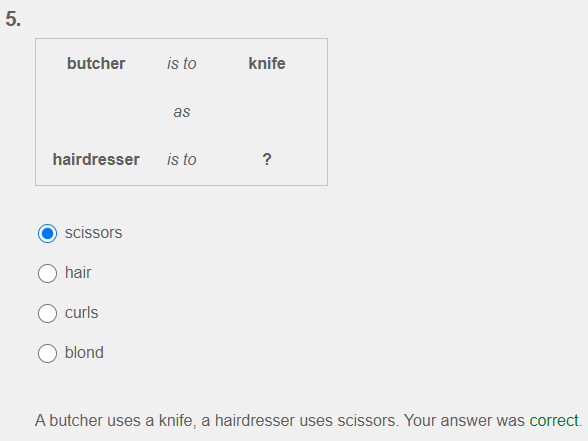

The GloVe model got this one right.

####  **6) warm is to hot as old is to ?**

Using the previously defined functions we get "antique" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('warm', 'hot')
options = [('old', 'oldest'),('old','history'),('old', 'years'),('old', 'antique')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('warm', 'hot')  as  ('old', 'antique') with a score of [0.05968165]


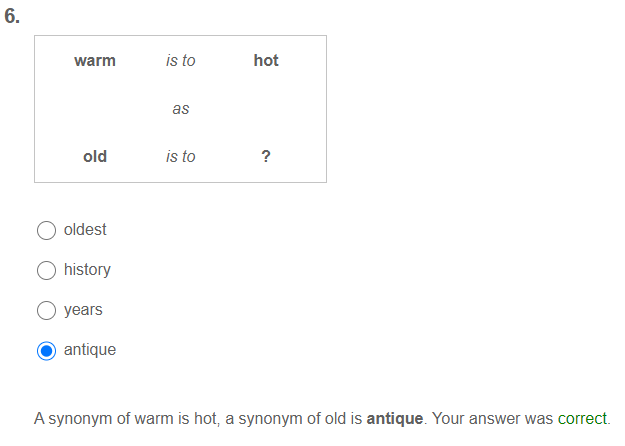

Another positive outcome, despite the low score of the analogy.

####  **7) Europe is to Spain as North America is to ?**

Using the previously defined functions we get "Venezuela" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('europe', 'spain')
options = [('north america', 'alaska'),('north america','canada'),('north america', 'venezuela'),('north america', 'new york')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('europe', 'spain')  as  ('north america', 'venezuela') with a score of [0.32843928]


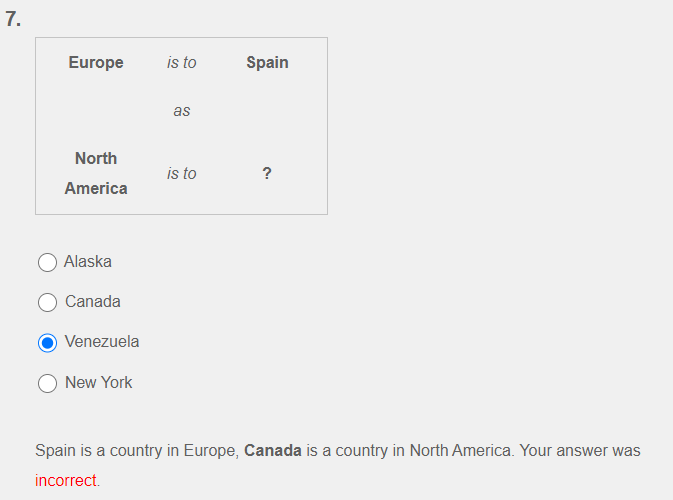

This is one is specially hard for the model because of the composite words, notice that we are taking the average of "North" and "America" and this might be different meaning compared to "North America". Also, it is interesting that Venezuela came up as the solution for the analogy, this is for sure one of the many biases that the text corpus introduces into the learning process. 

####  **8) earth is to ball as pancake is to ?**

Using the previously defined functions we get "soccer" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('earth', 'ball')
options = [('pancake', 'flat'),('pancake','flag'),('pancake', 'soccer'),('pancake', 'disc')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('earth', 'ball')  as  ('pancake', 'soccer') with a score of [0.07951007]


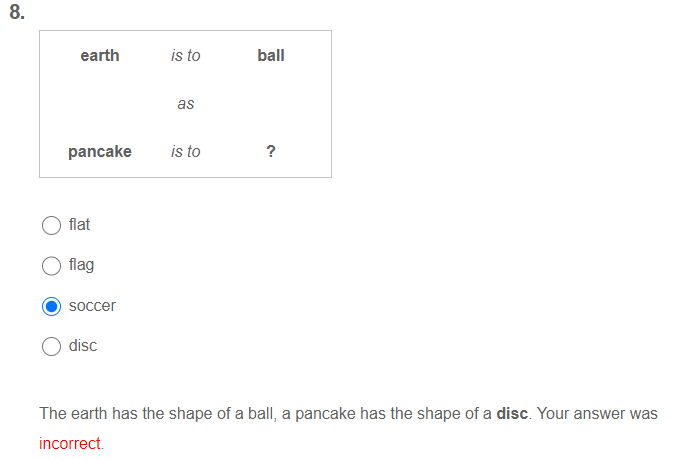

The GloVe model missed this one. We can clearly see the influence that the word ball had on choosing "soccer" as the answer. This shines light on a problem that word embeddings will always have at solving analogies, and that is to "throw away" meaning. For example, in this question we are asked to disregard underlying properties of the earth, and just focus on one single property that is shared with a ball, and that is that both are round. How can a machine know that it must disregard *hard-earned * knowledge, such as "balls are used to play soccer"? 

####  **9) bow is to arrow as ? is to bullet**

Using the previously defined functions we get "lead" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('bow', 'arrow')
options = [('defend', 'bullet'),('lead','bullet'),('shoot', 'bullet'),('gun', 'bullet')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('bow', 'arrow')  as  ('lead', 'bullet') with a score of [0.09932996]


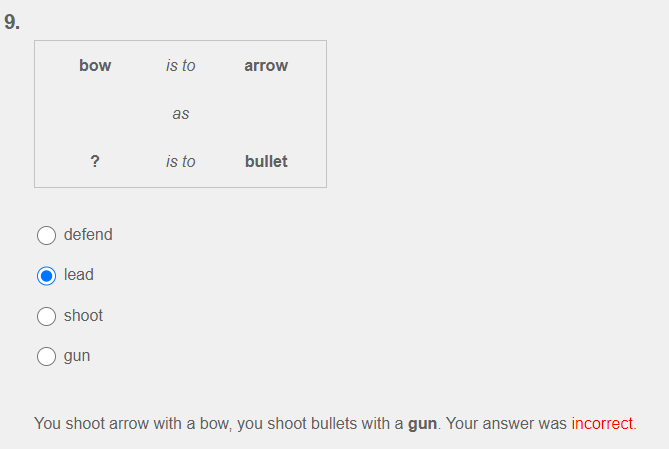

I think that, for this problem in particular, the GloVe model had a fair chance of getting the answer right. However, the confusion generated by the close relationship between lead and bullet is completely understandable. 

####  **10) prose is to poetry as conversation is to ?**

Using the previously defined functions we get "listening" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('prose', 'poetry')
options = [('conversation', 'song'),('conversation','poem'),('conversation', 'language'),('conversation', 'listening')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('prose', 'poetry')  as  ('conversation', 'listening') with a score of [0.18662931]


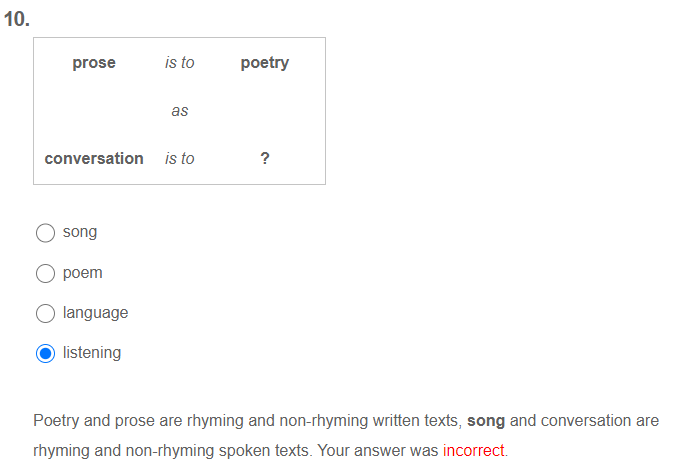

This one was a hard relationship to grasp for the machine. Even as a human, I am not sure if I would have solved this question correctly. 

####  **11) bridge is to river as ? is to ?**

Using the previously defined functions we get "tunnel : mountain" as the answer.

In [ ]:
#Use model_1 to solve the analogy
input=('bridge', 'river')
options = [('mountain', 'rails'),('subway','underground'),('tunnel', 'mountain'),('water', 'rock')]

best_option, best_score = solve_analogy_problem(model_1, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('bridge', 'river')  as  ('tunnel', 'mountain') with a score of [0.32805103]


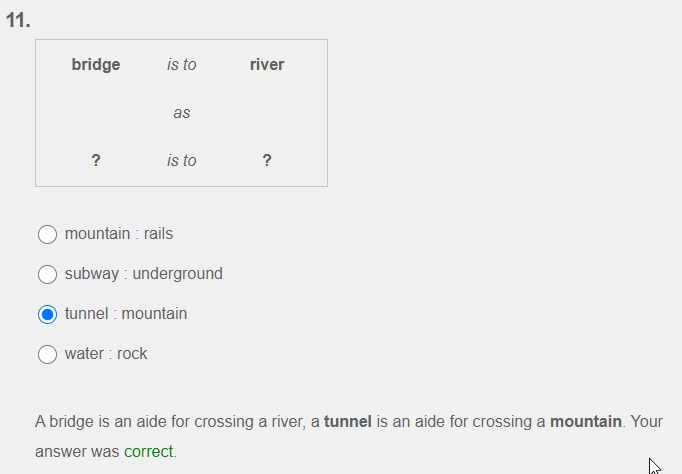

For the final question, the model got it right.

But, can we do something about the questions that the model got wrong? Let's explore this in the next section.

## Training a NEW model (**Model 2**) from scratch with manually generated training data

The question we want to answer is: **can we train a word embedding to solve this test?** To answer that question we first must train a word embedding model with our custom corpus.

The code and model is based on the Word2Vec library, and it is based on the following sources:

https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights

https://radimrehurek.com/gensim/models/word2vec.html

In [111]:
# Function to intersect 2 models, GloVe + Custom Corpus
def train_with_new_corpus(lines):
  """
  We process a given input called "lines" and break it down in tokenized
  sentences that Word2Vec can handle. Then we use the processed data 
  to train and extended version of the GloVe Model using Word2Vec
  """

  # Process inputs
  full_text = []
  for line in lines:
    processed_array = preprocessing(line.strip().split("."))
    full_text.extend([sentence for sentence in processed_array if len(sentence) > 0])

  # Initialize model with processed inputs
  model_2 = Word2Vec(size=300, min_count=1)
  model_2.build_vocab(full_text)
  total_examples = model_2.corpus_count

  # Load GloVe model in Word2Vec
  model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)

  # Extend the vocabulary 
  model_2.build_vocab([list(model.vocab.keys())], update=True)

  # This is the key part, intersect the weights of the 2 models
  model_2.intersect_word2vec_format("glove.6B.300d.txt", binary=False, lockf=1.0)

  # Train the extended model
  model_2.train(full_text, total_examples=total_examples, epochs=1500)
  return model_2


def train_from_scratch(lines):
  """
  Function to train a new word embeddings using Word2Vec. This is a brand new
  model using just a limited amount of input.
  """
  # Process inputs
  full_text = []
  for line in lines:
    processed_array = preprocessing(line.strip().split("."))
    full_text.extend([sentence for sentence in processed_array if len(sentence) > 0])

  # Initialize model with processed inputs
  model = Word2Vec(size=300, min_count=1)
  model.build_vocab(full_text)
  total_examples = model.corpus_count

  # Train the model
  model.train(full_text, total_examples=total_examples, epochs=1800)
  return model

The text corpus to train the custom model is based on short sentences that "explain" the analogy in the most humanly way possible. For example, to "explain to the model" why the answer to the analogy ***hip is to ankle as shoulder is to ___*** is **wrist**, I wrote this small text:


*Hip is to ankle as shoulder is to wrist. The first and third joint of the leg are the hip and ankle. The corresponding joints for the arm are the shoulder and wrist. The knee even though is part of the leg, is the second joint. So you get that:*
* *The knee is the second joint, the elbow is the second joint*
* *The hip is the first joint, the shoulder is the first joint.*
* *The ankle is the third joint, the wrist is the third joint.*

*All joints are made of bone. Shoulder is part of the arm.Each leg has a knee. Wrist is part of the arm.*

**NOTE 1:** The last sentences were introduced as "negative sampling".

**NOTE 2:** Repetition is key (as it is in any other classroom), and explaining the same concept in different ways including examples is also as important.

In [128]:
# Custom Training dataset
lines = ["The first and third joint of the leg are the hip and ankle. The corresponding joints for the arm are the shoulder and wrist.",
         "hip is to ankle as shoulder is to wrist",
         "The knee even though is part of the leg, is the second joint. So you get that:",
         "The knee is the second joint, the elbow is the second joint.",
         "The hip is the first joint, the shoulder is the first joint.",
         "The ankle is the third joint, the wrist is the third joint.",
         "All joints are made of bone.",
         "Shoulder is part of the arm",
         "Each leg has a knee.",
         "Wrist is part of the arm",

         "Earth is to ball as pancake is to soccer",
         "The earth has the shape of a ball, a pancake hast the shape of a disc.",
         "You can argue that the pancake is flat. But really, there is more to it.",
         "In fact, there is a property of roundness, in a way a ball is round as well as a disc is round.",
         "Flag is not a on option because is not even a shape.",

         "Spain is a country in Europe, Canada is a country in North America.",
         "Spain is a country",
         "Europe is a continent",
         "North America is a continent",
         "Canada is a country",
         "Europe is to Spain what North America is to Canada",
         "A country is part of a continent.",
         "A state is part of a country",
         "The right answer should be Canada because: Spain is in Europe, Canada is in North America",
         "Canada is a country, and Spain is a country",
         "What about Alaska? Well Alaska is a state, in the US",
         "Venezuela is in South America, so it doesn't apply",
         "New york is also a state, so it doesn't apply",
         "Canada is in America",
         "Canada is in the North",
         "I am going to Canada, means that I a going to North America.",

         "You shoot arrow with a bow, you shoot bullets with a gun.",
         "The same way a bow shoots one arrow, the gun shoots one bullet.",
         "While the bow is a weapon, and the gun is a weapon.",
         "Lead is just a material.", 
         "It is used to build bullets. Shoot is a verb, so it is not even a fair comparison.",
         "Defend is also a verb.",

         "prose is to poetry as conversation is to song.",
         "poetry and prose are rhyming and non-rhyming written texts, song and conversation are rhyming and non-rhyming spoken texts.",
         "Prose is the ordinary language people use in speaking or writing.", 
         "Poetry is beatiful, while prose is ugly.",
         "Poem is certainly not the right answer, a poem is a written form of poetry",
         "Prose is text, the same way poetry is text.",
         "A song is spoken, the same way a conversation is spoken",
         "Song is beatiful, while conversation is ugly",
         "A song has rhymes.",
         "Poetry has rhymes.",

         "All is to many as few is to none.",
         "For example, you can have all the coins, but if you lose one now you will only have many of the coins.",
         "The same goes with few and none. You can have a few coins, but if you lose one now you will have none of the coins.",
         "This is different than using few and some. You can say that you have some spare change, but is almost the same as saying that you a few coins.",
         "If you lose one coin from have a few coins, you still have some spare change.",
         "Obviously, always and never are not even comparable, as they both deal with time.",
         "You can be listening to a conversation, or you can be listening to a song.",

         "You can flip something from left to right, the same way you can flip something from horizontal to vertical.",
         "You can turn to the left, or turn to the right. But you can also take horizontal pictures or vertical pictures."
         ]

#Train model from scratch
model_2 = train_from_scratch(lines)

## Model 2  - Custom Word2Vec model

In the last piece of code we already trained the **model_2** with all the custom training text corpus. Now, let's execute all the questions that the GloVe model (**Model 1**) failed to answer correctly:

In [129]:
#Use model_2 to solve the analogy
input=('all', 'many')
options = [('few', 'some'),('few','never'),('few', 'none'),('few', 'always')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_2 to solve the analogy
input=('hip', 'ankle')
options = [('shoulder', 'knee'),('shoulder','bone'),('shoulder', 'wrist'),('shoulder', 'joint')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_2 to solve the analogy
input=('europe', 'spain')
options = [('north america', 'alaska'),('north america','canada'),('north america', 'venezuela'),('north america', 'new york')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_2 to solve the analogy
input=('earth', 'ball')
options = [('pancake', 'flat'),('pancake','flag'),('pancake', 'soccer'),('pancake', 'disc')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_2 to solve the analogy
input=('bow', 'arrow')
options = [('defend', 'bullet'),('lead','bullet'),('shoot', 'bullet'),('gun', 'bullet')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_2 to solve the analogy
input=('prose', 'poetry')
options = [('conversation', 'song'),('conversation','poem'),('conversation', 'language'),('conversation', 'listening')]

best_option, best_score = solve_analogy_problem(model_2, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('all', 'many')  as  ('few', 'none') with a score of [0.43403077]
('hip', 'ankle')  as  ('shoulder', 'wrist') with a score of [0.12682754]
('europe', 'spain')  as  ('north america', 'canada') with a score of [0.42938046]
('earth', 'ball')  as  ('pancake', 'disc') with a score of [0.49212787]
('bow', 'arrow')  as  ('gun', 'bullet') with a score of [0.64086956]
('prose', 'poetry')  as  ('conversation', 'song') with a score of [0.47664392]


As you can see, with this new model (**Model 2**) we are able to correctly predict the answer to the 6 analogies above. However, this model is not able to correctly predict on the 5 analogies that the original GloVe did, because we didn't do any training on that. For this reason, the next step is to try to "tune" the GloVe model with the "lessons learned" in **Model 2**. In other words, we want to see if we can train a delta on the original GloVe model to be able to answer all questions correctly. 

## Model 3 (Merged model)

Let's start by training the **model_3**, this is using the function train_with_new_corpus, which merges 2 models: Glove (**Model 1**) + Custom model (**Model 2**).

In [130]:
#Train model 3
model_3 = train_with_new_corpus(lines)

Finally, with this model we execute all the questions again to see the results.

In [133]:
#Use model_3 to solve the analogy
input=('evening', 'morning')
options = [('dinner', 'breakfast'),('dinner','soup'),('dinner', 'coffee'),('dinner', 'time')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('left', 'right')
options = [('horizontal', 'below'),('horizontal','middle'),('horizontal', 'down'),('horizontal', 'vertical')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('all', 'many')
options = [('few', 'some'),('few','never'),('few', 'none'),('few', 'always')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('butcher', 'knife')
options = [('hairdresser', 'scissors'),('hairdresser','hair'),('hairdresser', 'curls'),('hairdresser', 'blond')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('hip', 'ankle')
options = [('shoulder', 'knee'),('shoulder','bone'),('shoulder', 'wrist'),('shoulder', 'joint')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('warm', 'hot')
options = [('old', 'oldest'),('old','history'),('old', 'years'),('old', 'antique')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('europe', 'spain')
options = [('north america', 'alaska'),('north america','canada'),('north america', 'venezuela'),('north america', 'new york')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('earth', 'ball')
options = [('pancake', 'flat'),('pancake','flag'),('pancake', 'soccer'),('pancake', 'disc')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('bow', 'arrow')
options = [('defend', 'bullet'),('lead','bullet'),('shoot', 'bullet'),('gun', 'bullet')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('prose', 'poetry')
options = [('conversation', 'song'),('conversation','poem'),('conversation', 'language'),('conversation', 'listening')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

#Use model_3 to solve the analogy
input=('bridge', 'river')
options = [('mountain', 'rails'),('subway','underground'),('tunnel', 'mountain'),('water', 'rock')]

best_option, best_score = solve_analogy_problem(model_3, input, options)
print(input, " as ", best_option, "with a score of", best_score[0])

('evening', 'morning')  as  ('dinner', 'breakfast') with a score of [0.35718834]
('left', 'right')  as  ('horizontal', 'vertical') with a score of [-0.42239952]
('all', 'many')  as  ('few', 'some') with a score of [0.53588855]
('butcher', 'knife')  as  ('hairdresser', 'scissors') with a score of [0.392827]
('hip', 'ankle')  as  ('shoulder', 'knee') with a score of [0.23487869]
('warm', 'hot')  as  ('old', 'antique') with a score of [0.05968165]
('europe', 'spain')  as  ('north america', 'canada') with a score of [0.17854646]
('earth', 'ball')  as  ('pancake', 'disc') with a score of [-0.0955558]
('bow', 'arrow')  as  ('gun', 'bullet') with a score of [0.30482653]
('prose', 'poetry')  as  ('conversation', 'song') with a score of [0.10865094]
('bridge', 'river')  as  ('tunnel', 'mountain') with a score of [0.32805103]


As you can see in the output, there are 2 wrong answers:
* 'all' is to 'many' as 'few' is to 'some' (should have been 'none')
* 'hip' is to 'ankle' as 'shoulder' is to 'knee' (should have been 'wrist')

Which is interesting because these were questions that were initially incorrect using Model 1, then they were correct using Model 2, and finally in Model 3 they are incorrect. But why? The only explanation I can offer is that for this relationships, the effects of intersecting the word embedding vector from Model 2 were not enough to "persuade" the GloVe model into changing answers.

In fact, we can explore this. **For 'knee' vs 'wrist' we get**:

In [136]:
# Original analogy scores with model 1
calculate_analogy_words(model_1, 'hip', 'ankle', 'shoulder')

[('knee', 0.6818364858627319),
 ('sprained', 0.6759722232818604),
 ('elbow', 0.6325133442878723),
 ('wrist', 0.609483540058136),
 ('hamstring', 0.6079821586608887),
 ('injury', 0.5827159881591797),
 ('sprain', 0.5798239707946777),
 ('groin', 0.5781617164611816)]

In [134]:
# New analogy scores with model 3
calculate_analogy_words(model_3, 'hip', 'ankle', 'shoulder')

[('knee', 0.8136184811592102),
 ('wrist', 0.7753546237945557),
 ('leg', 0.7245821952819824),
 ('right', 0.7083331346511841),
 ('left', 0.7001976370811462),
 ('elbow', 0.6877087354660034),
 ('ball', 0.6861603260040283),
 ('arm', 0.6838819980621338)]

As you can see from the above. The word 'wrist' is better positioned in the rank of similarities of 
$$ ankle - hip + shoulder $$
but 'knee' is still the best option for the model. Is this bad? Not completely, on one side it means that we are not "overfitting" the model just to answer the questions correctly, and on the other side it could mean that there are some other qualities in 'knee' that are worth keeping. 

**For 'few' vs 'none' we get:**

In [137]:
calculate_analogy_words(model_1, 'all', 'many', 'few')

[('several', 0.7146081924438477),
 ('some', 0.6985302567481995),
 ('handful', 0.6616299152374268),
 ('numerous', 0.6084779500961304),
 ('dozen', 0.587744951248169),
 ('often', 0.5698710680007935),
 ('though', 0.5530471205711365),
 ('perhaps', 0.5495551228523254)]

In [135]:
calculate_analogy_words(model_3, 'all', 'many', 'few')

[('some', 0.927048921585083),
 ('have', 0.8995702266693115),
 ('even', 0.8959934115409851),
 ('but', 0.8893354535102844),
 ('are', 0.8892401456832886),
 ('also', 0.8882267475128174),
 ('as', 0.8833765983581543),
 ('they', 0.8820074796676636)]

The above is very interesting, because the word 'none' doesn't even show up in top 8 results. But looking at the other results and how they compare to the words 'all', 'many', and 'few' is understandable that the model does not prioritize the word 'none' to be in the "same realm" as the others.

## Conclusions

There are many interesting lessons and conclusions from this exercise. To name a few:

* Word embedding models can be relatively good at verbal reasoning in the form of analogies.
* Word embedding models can be trained easily to adapt on new information, and the newly created model can be incrementaly improved. 
* Some analogies are very hard to capture in a context-based word embedding model. For example, the numerical or quantitative properties of words cannot be introduced into the embedding vector at all. For example, the numbers 5 and 500 are used in the same context to convey different meanings as in "There are 5 people in the room" and "There are 500 people in the room". *This is an interesting opportunity to enhance the word embedding model.*
* We can have a very human-like way of training a word embedding model, just hav someone explain the concepts to the machine. Literally, Machine Learning.

And finally as an overall thought, word embeddings are definitely a very important innovation in the NLP area.

Thanks for reading.
